# ECE 498 DS Mini Project 2

# avk2@illinois.edu
# zinan2@illinois.edu
# jg8@illinois.edu

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np  
import datetime
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [2]:
he0 = pd.read_csv("Data/RelativeAbundance_HE0.csv")

### 1.  Microbiomes vary from person to person, and multiple samples are needed to verify the specifics of each microbiome.  Then, these samples are needed to figure out what the average abundance levels are and to identify any outliers.  We can use the different sets of microbes to identify the causal relationship between these microbes and cirrhosis.


### 2.  764 Samples Analyzed

In [3]:
cells= he0.shape[1]- 1
cells

764

### 3.  149 Microbes Identified

In [4]:
gene=he0['Microbe Name'].nunique()
gene

149

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization

#### Factorization of the joint probability distribution:
$$P(storagetemp,collectionmethod,contamination,labtime,quality)=$$

$$ P(quality | labtime,contamination)P(contamination | storagetemp,collectionmethod)P(labtime)P(storagetemp)P(collectionmethod)$$

### b. Parameters Required

#### The number of parameters required for defining the conditional probability:
$$ P(quality | labtime,contamination)P(contamination | storagetemp,collectionmethod)P(labtime)P(storagetemp)P(collectionmethod)$$

=4+4=8




### c. Constructing Probability Tables

##### import data

In [10]:
he1 = pd.read_csv("Data/QualityControl.csv")

he1.head()

,strtmp,coll,labtime,cont,qual
0,cold,nurse,short,low,good
1,cold,nurse,short,low,good
2,cold,nurse,short,low,bad
3,cold,nurse,short,high,good
4,cold,nurse,short,low,good


#### For storage temperature

In [11]:
strtmp={}
total=he1.shape[0]
for i in he1['strtmp'].unique():
     strtmp['strtmp='+i] = (he1['strtmp'] == i).sum()/total
strtmp

{'strtmp=cold': 0.8982, 'strtmp=cool': 0.1018}

P(storage temp=cold)=0.8982

P(storage temp=cool)=0.1018

#### For Collection Method

In [12]:
coll={}
for j in he1['coll'].unique():
    coll['coll='+j]=(he1['coll']==j).sum()/total
coll

{'coll=nurse': 0.8976, 'coll=patient': 0.1024}

P(Collection Method = Nurse)=0.8982

P(Collection Method = Patient)=0.1018

#### For Lab time

In [13]:
labtime={}
for k in he1['labtime'].unique():
    labtime['labtime='+k]=(he1['labtime']==k).sum()/total
labtime

{'labtime=short': 0.7956, 'labtime=long': 0.2044}

P(Lab time = long)=0.8982

P(lab time = short)=0.1018

#### For P(contamination|storage temp, collection method)

In [14]:
group= he1[['cont','strtmp','coll']]
df1= pd.DataFrame(data = np.ones([4,4]), columns = [ 'strtmp','coll','cont = high', 'cont = low'])
df1= df1.astype('str')

In [15]:
count = 0
for i in group['strtmp'].unique():
    for j in group['coll'].unique():
        for k in group['cont'].unique():
            val = ((group['cont'] == k) &(group['strtmp'] == i) & (group['coll'] == j)).sum()
            df1.at[count,'coll'] = j
            df1.at[count,'strtmp'] = i
            if k == 'high':
                df1.at[count,'cont = high'] = val/((group['strtmp'] == i) & (group['coll'] == j)).sum()
            else:
                df1.at[count,'cont = low'] = val/((group['strtmp'] == i) & (group['coll'] == j)).sum()
        count += 1
df1



,strtmp,coll,cont = high,cont = low
0,cold,nurse,0.0439832,0.956017
1,cold,patient,0.0765766,0.923423
2,cool,nurse,0.0884354,0.911565
3,cool,patient,0.838235,0.161765


#### For P(Quality|contamination, labtime)


In [16]:
group2= he1[['qual','cont','labtime']]
df2= pd.DataFrame(data = np.ones([4,4]), columns = [ 'cont','labtime','qual = good', 'qual = bad'])
df2= df2.astype('str')

In [17]:
newcount = 0
for i in group2['cont'].unique():
    for j in group2['labtime'].unique():
        for k in group2['qual'].unique():
            val = ((group2['qual'] == k) &(group2['cont'] == i) & (group2['labtime'] == j)).sum()
            df2.at[newcount,'labtime'] = j
            df2.at[newcount,'cont'] = i
            if k == 'good':
                df2.at[newcount,'qual = good'] = val/((group2['cont'] == i) & (group2['labtime'] == j)).sum()
            else:
                df2.at[newcount,'qual = bad'] = val/((group2['cont'] == i) & (group2['labtime'] == j)).sum()
        newcount += 1
df2


,cont,labtime,qual = good,qual = bad
0,low,short,0.957093,0.0429069
1,low,long,0.919003,0.0809969
2,high,short,0.935743,0.064257
3,high,long,0.0338983,0.966102


### d. Final Probability Tables

#### Calculate P(quality|Storage Temp, Collection Method, Lab Time)

In [18]:
df3= pd.DataFrame(data = np.ones([8,5]), columns = [ 'strtmp','coll','labtime','qual = good', 'qual = bad'])
df3= df3.astype('str')
idx=0

for i in he1['strtmp'].unique():
    for j in he1['coll'].unique():
        for k in he1['labtime'].unique():
            data= (df2[df2['labtime']== k]['qual = good'].values).astype(float)
            data2 = (df1[(df1['strtmp'] == i) & (df1['coll']== j)][['cont = high', 'cont = low']].values).astype(float)
            df3.at[idx, 'strtmp'] = i
            df3.at[idx, 'coll'] = j
            df3.at[idx, 'labtime'] = k
            df3.at[idx, 'qual = good'] = float(data2@data[::-1])
            df3.at[idx, 'qual = bad'] = 1 - float(data2@data[::-1])
            idx += 1
df3

,strtmp,coll,labtime,qual = good,qual = bad
0,cold,nurse,short,0.956154,0.043846
1,cold,nurse,long,0.880073,0.119927
2,cold,patient,short,0.955458,0.0445419
3,cold,patient,long,0.851225,0.148775
4,cool,nurse,short,0.955205,0.044795
5,cool,nurse,long,0.840729,0.159271
6,cool,patient,short,0.939197,0.0608033
7,cool,patient,long,0.177077,0.822923


### e. Cleaning the dataset

In [19]:
print(df3[df3['qual = bad'] >= 0.5], '\n')


  strtmp     coll labtime qual = good qual = bad
7   cool  patient    long    0.177077   0.822923 



**Note:**Printed are the conditions under which the quality is bad. Therefore we drop the events where labtime is long,storage temp is cool and collection method is by patient

In [20]:


inf0 = pd.read_csv("Data/BayesInferenceHE0.csv")
inf1 = pd.read_csv("Data/BayesInferenceHE1.csv")
newinf0=inf0.copy()
newinf1=inf1.copy()
#newinf0 = inf0.drop(inf0[(inf0['labtime'] =='long')&(inf0['strtmp'] =='cool')&(inf0['coll'] =='patient')].values,axis=0)
newinf0=inf0[(inf0['labtime'] !='long')|(inf0['strtmp'] !='cool')|(inf0['coll'] !='patient')]
newinf1=inf1[(inf1['labtime'] !='long')|(inf1['strtmp'] !='cool')|(inf1['coll'] !='patient')]

In [21]:
he0 = pd.read_csv("Data/RelativeAbundance_HE0.csv")
he1 = pd.read_csv("Data/RelativeAbundance_HE1.csv")
he0.head()

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_754,HE0Sample_755,HE0Sample_756,HE0Sample_757,HE0Sample_758,HE0Sample_759,HE0Sample_760,HE0Sample_761,HE0Sample_762,HE0Sample_763
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004464,0.004636,0.004046,0.005518,0.005073,0.003527,0.005413,0.003140,0.002998,0.004829
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.010603,0.013565,0.012139,0.012875,0.013294,0.014107,0.012694,0.013082,0.008244,0.010401
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.003906,0.002919,0.004782,0.006070,0.003498,0.004408,0.004853,0.004012,0.004310,0.005758
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.005394,0.004979,0.004598,0.005518,0.005597,0.004761,0.004293,0.005233,0.004497,0.005386
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.004092,0.003777,0.004782,0.004598,0.003848,0.004585,0.003360,0.004186,0.004684,0.002043


In [22]:
newhe0 = he0.drop(inf0[(inf0['labtime'] =='long')&(inf0['strtmp'] =='cool')&(inf0['coll'] =='patient')]['SampleName'].values,axis=1)
newhe1 = he1.drop(inf1[(inf1['labtime'] =='long')&(inf1['strtmp'] =='cool')&(inf1['coll'] =='patient')]['SampleName'].values,axis=1)
newhe0.head()

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_689,HE0Sample_690,HE0Sample_691,HE0Sample_692,HE0Sample_693,HE0Sample_694,HE0Sample_695,HE0Sample_696,HE0Sample_697,HE0Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004681,0.005588,0.004256,0.003755,0.004995,0.006198,0.006096,0.003961,0.003970,0.005229
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.007489,0.011874,0.011103,0.014661,0.009301,0.010331,0.012716,0.011195,0.011731,0.014642
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.005055,0.002095,0.005736,0.004291,0.006545,0.004132,0.004877,0.004823,0.001985,0.004532
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.004306,0.003318,0.004626,0.004112,0.004823,0.005447,0.004877,0.003961,0.003609,0.003486
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.005242,0.002445,0.005736,0.005006,0.004306,0.004884,0.002613,0.004650,0.005234,0.004183


In [23]:
he1.head()

,Microbe Name,HE1Sample_0,HE1Sample_1,HE1Sample_2,HE1Sample_3,HE1Sample_4,HE1Sample_5,HE1Sample_6,HE1Sample_7,HE1Sample_8,...,HE1Sample_754,HE1Sample_755,HE1Sample_756,HE1Sample_757,HE1Sample_758,HE1Sample_759,HE1Sample_760,HE1Sample_761,HE1Sample_762,HE1Sample_763
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004864,0.004041,0.005630,0.005046,0.005041,0.005278,0.004005,0.003700,0.004295,...,0.004154,0.004178,0.003416,0.004565,0.004000,0.004509,0.005419,0.007286,0.004056,0.005797
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.011985,0.012124,0.010732,0.012074,0.009001,0.012559,0.013234,0.011284,0.011391,...,0.012463,0.012709,0.011104,0.011414,0.011478,0.007935,0.015906,0.009341,0.009956,0.007202
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.005211,0.003866,0.004926,0.004505,0.005401,0.005461,0.005050,0.003330,0.003922,...,0.003808,0.005571,0.004100,0.004390,0.005217,0.003968,0.003146,0.004110,0.004240,0.004391
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003995,0.003866,0.004046,0.005406,0.003600,0.006189,0.003308,0.004255,0.004482,...,0.003981,0.003830,0.004783,0.004214,0.005565,0.003968,0.004195,0.005044,0.004609,0.004567
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.002953,0.003514,0.004574,0.005046,0.003420,0.004186,0.004701,0.004624,0.003361,...,0.003116,0.003656,0.003758,0.004917,0.005043,0.003787,0.004020,0.003363,0.005531,0.006499


In [24]:
newhe1.head()

,Microbe Name,HE1Sample_0,HE1Sample_1,HE1Sample_2,HE1Sample_3,HE1Sample_4,HE1Sample_5,HE1Sample_6,HE1Sample_7,HE1Sample_8,...,HE1Sample_689,HE1Sample_690,HE1Sample_691,HE1Sample_692,HE1Sample_693,HE1Sample_694,HE1Sample_695,HE1Sample_696,HE1Sample_697,HE1Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004864,0.004041,0.005630,0.005046,0.005041,0.005278,0.004005,0.003700,0.004295,...,0.005573,0.004854,0.005412,0.004985,0.004070,0.003940,0.003880,0.004454,0.003743,0.005301
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.011985,0.012124,0.010732,0.012074,0.009001,0.012559,0.013234,0.011284,0.011391,...,0.010786,0.011963,0.011571,0.010657,0.013136,0.009381,0.012875,0.009280,0.010479,0.009322
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.005211,0.003866,0.004926,0.004505,0.005401,0.005461,0.005050,0.003330,0.003922,...,0.004494,0.004508,0.002613,0.005672,0.003330,0.005253,0.004409,0.005011,0.005801,0.005301
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003995,0.003866,0.004046,0.005406,0.003600,0.006189,0.003308,0.004255,0.004482,...,0.004494,0.005721,0.004479,0.002922,0.005365,0.004503,0.003527,0.005568,0.004304,0.006946
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.002953,0.003514,0.004574,0.005046,0.003420,0.004186,0.004701,0.004624,0.003361,...,0.002876,0.003467,0.004479,0.002922,0.003885,0.004690,0.004233,0.006496,0.003743,0.006215


## 2. Data Standardization

### 1. Verify Relative Abundance

In [25]:

b=newhe0.sum(axis=0)

x=[]
for j in range(1,b.size):
    if (b[j]>1+10e-10)|(b[j]<1-10e-10):
        x.append(j)
b.head()
print(x)

[]


In [26]:
b=newhe1.sum(axis=0)

y=[]
for j in range(1,b.size):
    if (b[j]>1+10e-10)|(b[j]<1-10e-10):
        y.append(j)
b.head()
print(y)

[]


Not a single colomn is found to have a different sum other than 1. That means we are getting a good relative abundance data.

### 2. Discussion on Relative Abundance Data

The benefits of the Relative Abundance Data is to get compositional data that conforms to specific patterns that are among the best-known and most-studied patterns, which might be helpful to the study; however the Data might omitt some of the components that are not considered within all the species when the relative abundance data is biased or not reflect the real world abundance, therefore these information would be lost if the normalization is performed.

In [27]:
newhe0.iloc[:,:].head()

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_689,HE0Sample_690,HE0Sample_691,HE0Sample_692,HE0Sample_693,HE0Sample_694,HE0Sample_695,HE0Sample_696,HE0Sample_697,HE0Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004681,0.005588,0.004256,0.003755,0.004995,0.006198,0.006096,0.003961,0.003970,0.005229
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.007489,0.011874,0.011103,0.014661,0.009301,0.010331,0.012716,0.011195,0.011731,0.014642
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.005055,0.002095,0.005736,0.004291,0.006545,0.004132,0.004877,0.004823,0.001985,0.004532
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.004306,0.003318,0.004626,0.004112,0.004823,0.005447,0.004877,0.003961,0.003609,0.003486
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.005242,0.002445,0.005736,0.005006,0.004306,0.004884,0.002613,0.004650,0.005234,0.004183


In [28]:
newhe0=newhe0.set_index(['Microbe Name'])
newhe1=newhe1.set_index(['Microbe Name'])

### 3. Visual Inspection

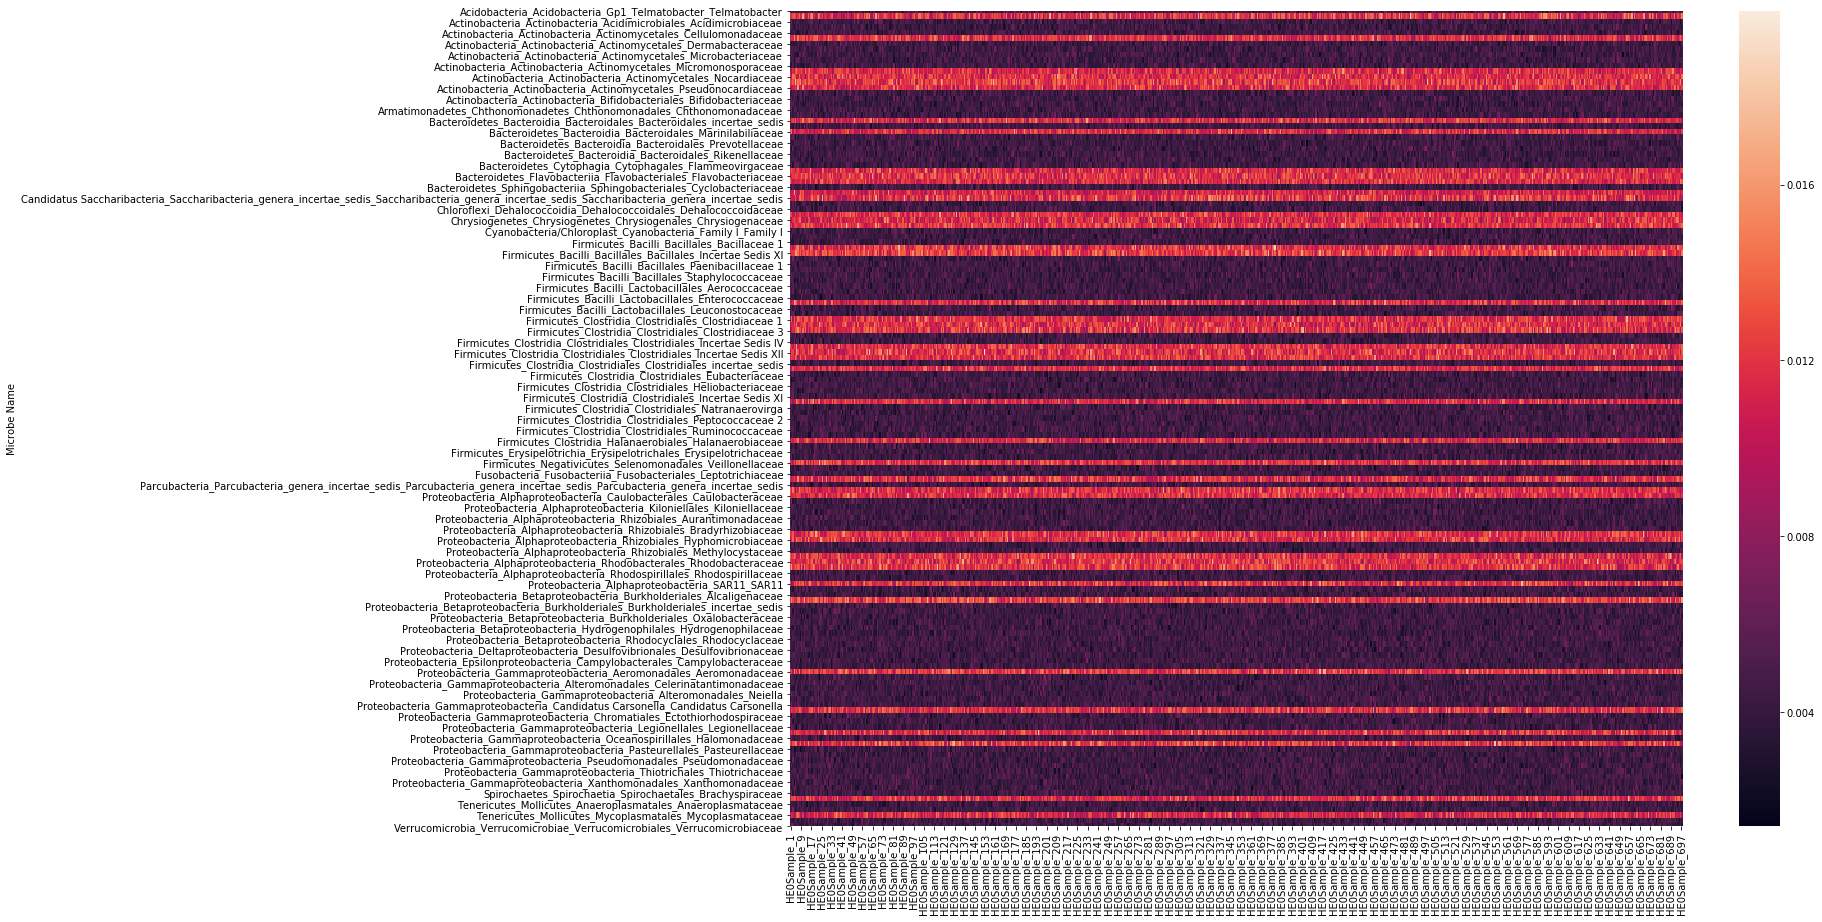

In [29]:
plt.figure(figsize=(20, 15))
sns.heatmap(newhe0.iloc[:,1:])
plt.show()




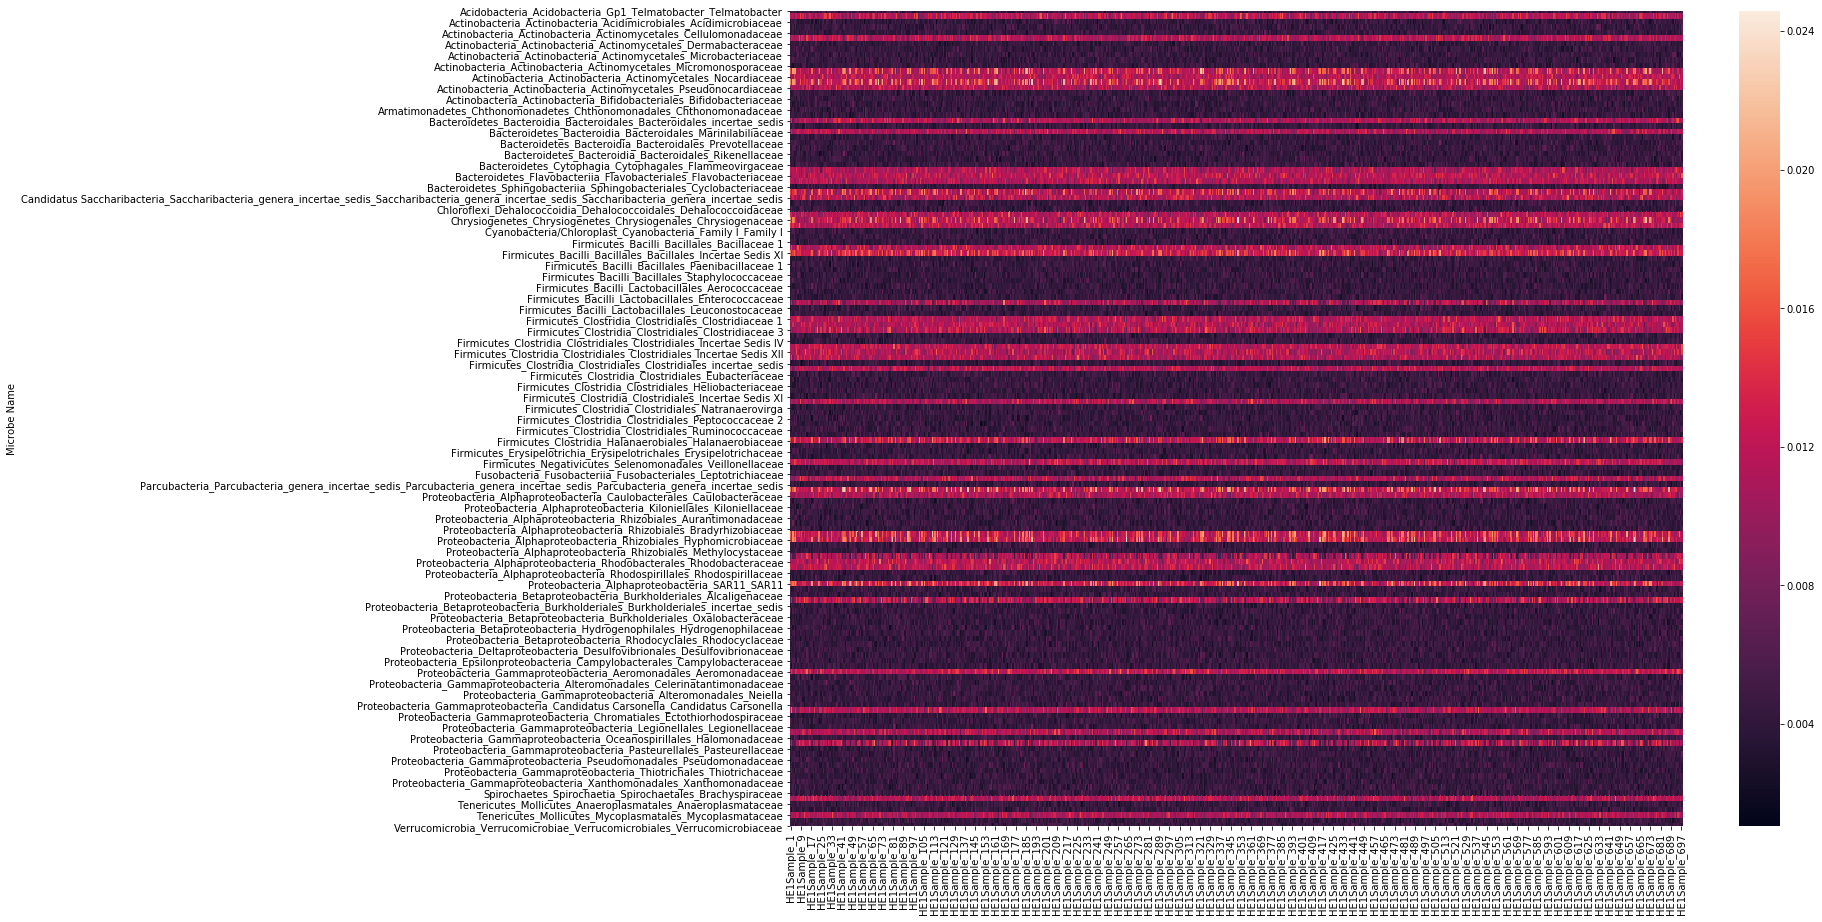

In [30]:
plt.figure(figsize=(20, 15))
sns.heatmap(newhe1.iloc[:,1:])
plt.show()

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [31]:
from scipy import stats

p_values = []
for i in range(newhe0.shape[0]):
    p_value = stats.ks_2samp(newhe0.iloc[i,1:], newhe1.iloc[i,1:])
    p_values.append(p_value[1])

p_values = pd.Series(p_values)
p_values

0      0.179867
1      0.003204
2      0.109910
3      0.539701
4      0.937086
         ...   
144    0.124858
145    0.073682
146    0.022342
147    0.718479
148    0.804149
Length: 149, dtype: float64

### b. Null Hypothesis of the KS Test in our Context

**Null Hypothesis:** A certain microbe, for example Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3, for which abundance is not altered since the difference between the abundance in the two data sets RelativeAbundance_HE0 and RelativeAbundance_HE1 for Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3 is not statistically significant.

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [32]:
alphas = [0.1, 0.05, 0.01, 0.005, 0.001]
counts = []
for alpha in alphas:
    count = p_values[p_values.iloc[:] < alpha].count()
    counts.append(count)
count_table = pd.DataFrame(data = np.ones([5,2]), columns = [ 'alpha' , 'count'])
for i in range(len(counts)):
    count_table.iloc[i, 0] = alphas[i]
    count_table.iloc[i, 1] = counts[i]
count_table

,alpha,count
0,0.100,50.0
1,0.050,37.0
2,0.010,27.0
3,0.005,26.0
4,0.001,21.0


## 2. Multiple Testing

### a. P-value

The p-value or probability value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct。 In this case it represents the threshold of whether a certain microbe's abundance is altered or not. When the p-value is smaller than 0.05 it means the null hypothesis should be rejected and teh microbe's abundance is altered, because the difference observed in the two samples are statistically significant. If the p-value is larger than 0.05 than the null hypothesis is not too be rejected thus the abundance is not altered.

### b. P-value Distribution

The p-value follows uniform distribution if null hypothesis is true

### c. Expected Number of Significant p-values

In [33]:
Sig_pval= pd.DataFrame(data = np.ones([5,3]), columns = ['alpha', 'Expected' , 'Actual'])
total_vals = len(p_values)
for i in range(len(count_table)):
    Sig_pval['alpha'][i] = count_table['alpha'][i]
    Sig_pval['Expected'][i]= count_table['alpha'][i]*total_vals
    Sig_pval['Actual'][i] = count_table['count'][i]
Sig_pval

,alpha,Expected,Actual
0,0.100,14.900,50.0
1,0.050,7.450,37.0
2,0.010,1.490,27.0
3,0.005,0.745,26.0
4,0.001,0.149,21.0


### d. Q-Q plot of p-values

#### i. 

In [36]:
sample = np.random.uniform(low= 0, high=1, size = total_vals)


#### ii. 

In [37]:
pvals_log= -np.log10(p_values)
sample_log = -np.log10(sample)

#### iii. 

In [38]:
pvals_log= sorted(pvals_log)
sample_log = sorted(sample_log)


#### iv. 

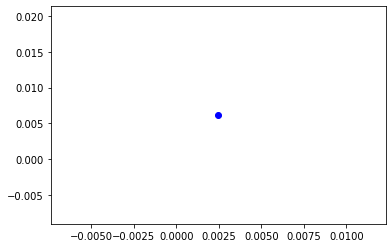

In [39]:
plt.scatter(sample_log[0], pvals_log[0], label= 'Observation', c='blue')
plt.show()

#### v. 

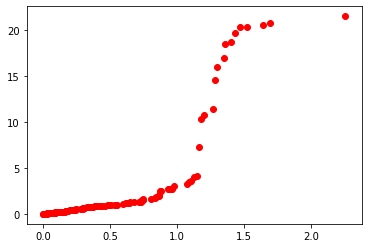

In [40]:
plt.scatter(sample_log, pvals_log, c='red')
plt.show()

#### vi. 

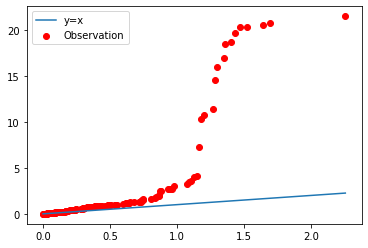

In [41]:
plt.scatter(sample_log, pvals_log, label= 'Observation', c='red')
plt.plot(np.linspace(start= 0 , stop= sample_log[-1], num=total_vals),np.linspace(start= 0 , stop= sample_log[-1], num=total_vals), label='y=x')
plt.legend()

plt.show()

### e. Follow-up Questions

#### i. 

Taking the -log10 value of the p-values would make the graph more intuitive and visible(-log10(0,1)=0.1, 0.01 becomes 2, 0.001 becomes 3, etc.) In this case the final graph represented are more likely in a linear fashion and easy to represent;otherwise the p_values, since they are exponentially increasing in comparison would create huge gap on the x axis.

#### ii. 

The plot does not aligh with x=y therefore the null hypothesis is not true, therefore the abundance of genes are indeed altered between the two different samples.

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

#### HE0

In [42]:
newhe0.T.head()

Microbe Name,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,Actinobacteria_Actinobacteria_Acidimicrobiales_Acidimicrobiaceae,Actinobacteria_Actinobacteria_Actinomycetales_Actinomycetaceae,Actinobacteria_Actinobacteria_Actinomycetales_Cellulomonadaceae,Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae,Actinobacteria_Actinobacteria_Actinomycetales_Dermabacteraceae,Actinobacteria_Actinobacteria_Actinomycetales_Geodermatophilaceae,Actinobacteria_Actinobacteria_Actinomycetales_Microbacteriaceae,Actinobacteria_Actinobacteria_Actinomycetales_Micrococcaceae,...,Proteobacteria_Gammaproteobacteria_Xanthomonadales_Sinobacteraceae,Proteobacteria_Gammaproteobacteria_Xanthomonadales_Xanthomonadaceae,Proteobacteria_Zetaproteobacteria_Mariprofundales_Mariprofundaceae,Spirochaetes_Spirochaetia_Spirochaetales_Brachyspiraceae,Synergistetes_Synergistia_Synergistales_Synergistaceae,Tenericutes_Mollicutes_Anaeroplasmatales_Anaeroplasmataceae,Tenericutes_Mollicutes_Haloplasmatales_Haloplasmataceae,Tenericutes_Mollicutes_Mycoplasmatales_Mycoplasmataceae,Thermodesulfobacteria_Thermodesulfobacteria_Thermodesulfobacteriales_Thermodesulfobacteriaceae,Verrucomicrobia_Verrucomicrobiae_Verrucomicrobiales_Verrucomicrobiaceae
HE0Sample_0,0.004239,0.013269,0.003502,0.003870,0.004976,0.012532,0.004055,0.004055,0.004792,0.005898,...,0.003317,0.006635,0.005529,0.004792,0.013269,0.004792,0.004976,0.013638,0.003870,0.005345
HE0Sample_1,0.004345,0.012312,0.005251,0.005794,0.003802,0.010683,0.004345,0.006156,0.004527,0.005251,...,0.005251,0.005251,0.005613,0.005794,0.010139,0.003983,0.004345,0.010139,0.003802,0.004164
HE0Sample_2,0.004423,0.011611,0.006082,0.005345,0.004239,0.011426,0.003502,0.004792,0.005345,0.004239,...,0.004607,0.004055,0.003686,0.006819,0.012532,0.004976,0.004792,0.011611,0.004423,0.006450
HE0Sample_3,0.004463,0.013033,0.003749,0.004106,0.004285,0.011427,0.003571,0.004999,0.004642,0.004821,...,0.004106,0.005178,0.004642,0.003392,0.012676,0.004285,0.007499,0.010891,0.003571,0.006427
HE0Sample_4,0.005372,0.013689,0.004332,0.002946,0.005198,0.014902,0.003639,0.004159,0.003812,0.003292,...,0.005025,0.001733,0.005718,0.006758,0.013343,0.003985,0.004332,0.009184,0.004159,0.003466


In [43]:
pca0 = PCA(n_components = newhe0.shape[0], svd_solver='full')

In [44]:
newhe0_pca2 = pca0.fit_transform(newhe0.T)

#### HE1

In [45]:
newhe1.T.head()

Microbe Name,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,Actinobacteria_Actinobacteria_Acidimicrobiales_Acidimicrobiaceae,Actinobacteria_Actinobacteria_Actinomycetales_Actinomycetaceae,Actinobacteria_Actinobacteria_Actinomycetales_Cellulomonadaceae,Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae,Actinobacteria_Actinobacteria_Actinomycetales_Dermabacteraceae,Actinobacteria_Actinobacteria_Actinomycetales_Geodermatophilaceae,Actinobacteria_Actinobacteria_Actinomycetales_Microbacteriaceae,Actinobacteria_Actinobacteria_Actinomycetales_Micrococcaceae,...,Proteobacteria_Gammaproteobacteria_Xanthomonadales_Sinobacteraceae,Proteobacteria_Gammaproteobacteria_Xanthomonadales_Xanthomonadaceae,Proteobacteria_Zetaproteobacteria_Mariprofundales_Mariprofundaceae,Spirochaetes_Spirochaetia_Spirochaetales_Brachyspiraceae,Synergistetes_Synergistia_Synergistales_Synergistaceae,Tenericutes_Mollicutes_Anaeroplasmatales_Anaeroplasmataceae,Tenericutes_Mollicutes_Haloplasmatales_Haloplasmataceae,Tenericutes_Mollicutes_Mycoplasmatales_Mycoplasmataceae,Thermodesulfobacteria_Thermodesulfobacteria_Thermodesulfobacteriales_Thermodesulfobacteriaceae,Verrucomicrobia_Verrucomicrobiae_Verrucomicrobiales_Verrucomicrobiaceae
HE1Sample_0,0.004864,0.011985,0.005211,0.003995,0.002953,0.011638,0.007295,0.006253,0.004169,0.005906,...,0.004690,0.005385,0.003995,0.004864,0.014070,0.005211,0.002953,0.012507,0.005906,0.004516
HE1Sample_1,0.004041,0.012124,0.003866,0.003866,0.003514,0.009840,0.004744,0.004744,0.004744,0.005271,...,0.004920,0.004393,0.003514,0.004744,0.011422,0.004920,0.004744,0.009840,0.004217,0.004920
HE1Sample_2,0.005630,0.010732,0.004926,0.004046,0.004574,0.012491,0.004222,0.004398,0.004046,0.005102,...,0.004398,0.003871,0.004926,0.003871,0.012139,0.004750,0.002463,0.010204,0.005102,0.004222
HE1Sample_3,0.005046,0.012074,0.004505,0.005406,0.005046,0.011353,0.004325,0.004505,0.004686,0.006127,...,0.004686,0.005226,0.005587,0.005226,0.010993,0.004505,0.005226,0.010993,0.004505,0.003604
HE1Sample_4,0.005041,0.009001,0.005401,0.003600,0.003420,0.009901,0.005041,0.005401,0.003780,0.004860,...,0.005041,0.005401,0.003600,0.004860,0.009541,0.004320,0.003960,0.011161,0.003420,0.006841


In [46]:
pca1 = PCA(n_components = newhe1.shape[0], svd_solver='full')


### b. Ordering Components

#### HE0

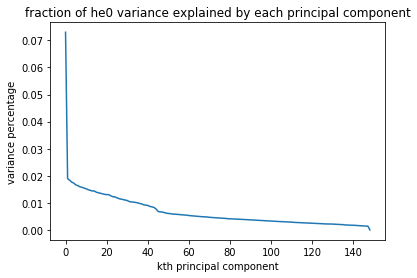

In [47]:
variance_explained0 = pca0.explained_variance_ratio_
plt.plot(variance_explained0)
plt.title('fraction of he0 variance explained by each principal component')
plt.ylabel('variance percentage')
plt.xlabel('kth principal component')
plt.show()

In [48]:
cumulative_variance0 = variance_explained0.copy()

for i in range(1, len(variance_explained0)):
    cumulative_variance0[i] = cumulative_variance0[i] + cumulative_variance0[i-1]

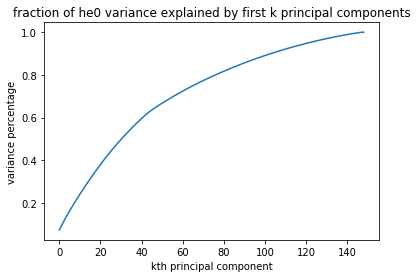

In [49]:
plt.plot(cumulative_variance0)
plt.title('fraction of he0 variance explained by first k principal components')
plt.ylabel('variance percentage')
plt.xlabel('kth principal component')
plt.show()

In [50]:
np.where(cumulative_variance0 >= 0.3)[0][0]

15

**16 principal components are needed in order to explain 30% of the total variance of HE0.**

#### HE1

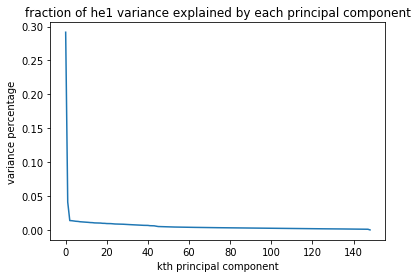

In [51]:
newhe1_pca = pca1.fit_transform(newhe1.T)

variance_explained1 = pca1.explained_variance_ratio_
plt.plot(variance_explained1)
plt.title('fraction of he1 variance explained by each principal component')
plt.ylabel('variance percentage')
plt.xlabel('kth principal component')
plt.show()

In [52]:
cumulative_variance1 = variance_explained1.copy()

for i in range(1, len(variance_explained1)):
    cumulative_variance1[i] = cumulative_variance1[i] + cumulative_variance1[i-1]
    

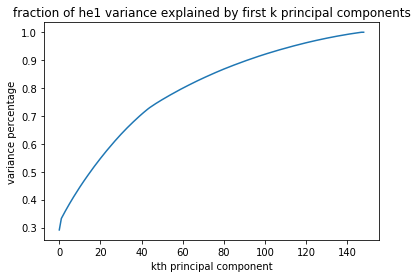

In [53]:
plt.plot(cumulative_variance1)
plt.title('fraction of he1 variance explained by first k principal components')
plt.ylabel('variance percentage')
plt.xlabel('kth principal component')
plt.show()

In [54]:
np.where(cumulative_variance1 >= 0.3)[0][0]

1

**2 principal components are needed in order to explain 30% of the total variance of HE0.**

### c. Scatter Plot of Microbe Abundance

#### HE0

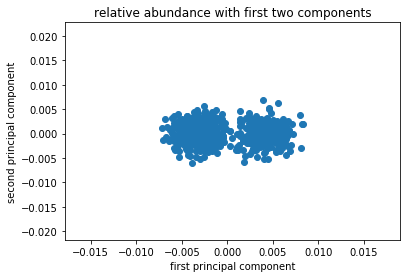

In [55]:
# plot
pca0_plot = PCA(n_components = 2, svd_solver='full') # first 2 pc for visualization
newhe0_plot = pca0_plot.fit_transform(newhe0.T)

x = newhe0_plot.T[0]
y = newhe0_plot.T[1]
plt.scatter(x, y)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.title('relative abundance with first two components')
plt.show()

The HE0 can be roughly divided into two clusters and they are close to each other. 

#### HE1

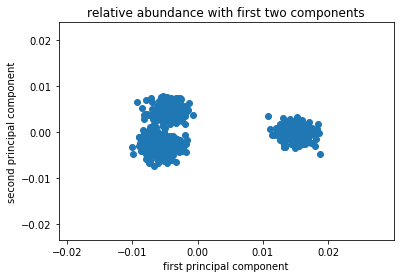

In [56]:
# plot
pca1_plot = PCA(n_components = 2, svd_solver='full') # first 2 pc for visualization
newhe1_plot = pca1_plot.fit_transform(newhe1.T)

x = newhe1_plot.T[0]
y = newhe1_plot.T[1]
plt.scatter(x, y)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.title('relative abundance with first two components')
plt.show()

The HE1 can be roughly divided into three groups, where two of them are similar to each other.

## 2. t-SNE

### a. Performing t-SNE

In [57]:
newhe0_plot_tsne = TSNE(n_components=2, random_state=42).fit_transform(newhe0.T)
newhe1_plot_tsne = TSNE(n_components=2, random_state=42).fit_transform(newhe1.T)

In [58]:
def plot(data_2d, xlabel, ylabel, title, colors=None):
    x = data_2d.T[0]
    y = data_2d.T[1]
    plt.scatter(x, y, c = colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

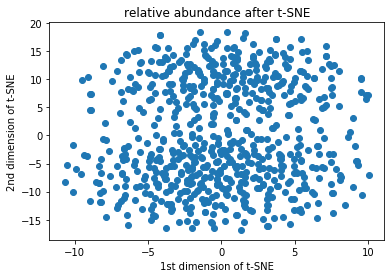

In [59]:
plot(newhe0_plot_tsne, '1st dimension of t-SNE', '2nd dimension of t-SNE', 'relative abundance after t-SNE')

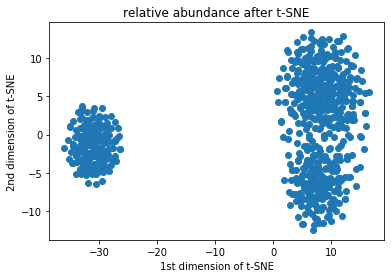

In [60]:
plot(newhe1_plot_tsne, '1st dimension of t-SNE', '2nd dimension of t-SNE', 'relative abundance after t-SNE')

In [61]:
newhe0_plot_tsne = TSNE(n_components=2, random_state=62).fit_transform(newhe0.T)
newhe1_plot_tsne = TSNE(n_components=2, random_state=62).fit_transform(newhe1.T)

In [64]:
def plot(data_2d, xlabel, ylabel, title, colors=None):
    x = data_2d.T[0]
    y = data_2d.T[1]
    plt.scatter(x, y, c = colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

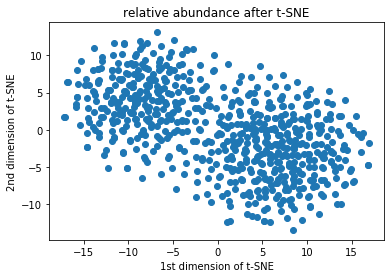

In [63]:
plot(newhe0_plot_tsne, '1st dimension of t-SNE', '2nd dimension of t-SNE', 'relative abundance after t-SNE')

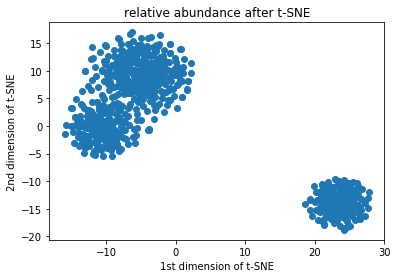

In [65]:
plot(newhe1_plot_tsne, '1st dimension of t-SNE', '2nd dimension of t-SNE', 'relative abundance after t-SNE')

In [66]:
newhe0_plot_tsne = TSNE(n_components=2, random_state=82).fit_transform(newhe0.T)
newhe1_plot_tsne = TSNE(n_components=2, random_state=82).fit_transform(newhe1.T)

In [67]:
def plot(data_2d, xlabel, ylabel, title, colors=None):
    x = data_2d.T[0]
    y = data_2d.T[1]
    plt.scatter(x, y, c = colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

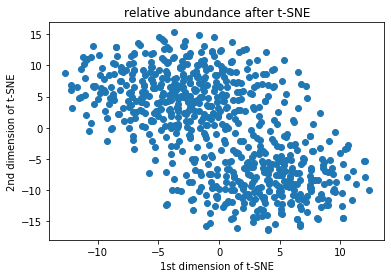

In [68]:
plot(newhe0_plot_tsne, '1st dimension of t-SNE', '2nd dimension of t-SNE', 'relative abundance after t-SNE')

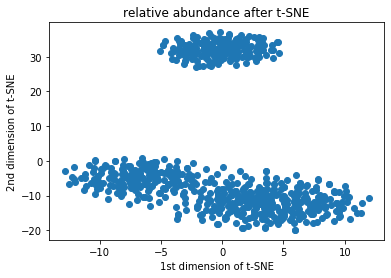

In [69]:
plot(newhe1_plot_tsne, '1st dimension of t-SNE', '2nd dimension of t-SNE', 'relative abundance after t-SNE')

There are two clsuters in HE0 after t-SNE and three clusters in HE1 after t-SNE. As the aim of t-SNE is not to maximize the variance remained, the intra-cluster distance after t-SNE are larger and each cluster spans a wider range. The performance of t-SNE depends on the initialization state. 

### b. Comparing with PCA

**Similarities**: The number of clusters are the same. There are two clusters for HE0 and three clusters for HE1

**Differences**: boundaries of data after PCA are easier to find as the data seems to have a relatively larger inter-cluster distance and smaller intra-cluster distance, while in t-SNE, the boudaries are vague. 

## 3. Clustering

### a. K-Means

In [70]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(newhe0.T)
    Sum_of_squared_distances.append(km.inertia_)

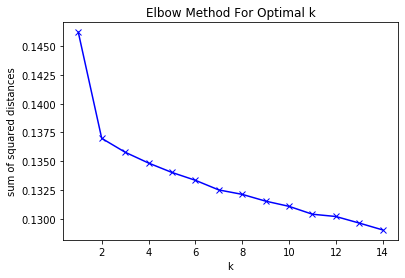

In [71]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

After k=2, sum of squared distance doesn't change much, so we choose k=2 for HE0.

In [72]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(newhe1.T)
    Sum_of_squared_distances.append(km.inertia_)

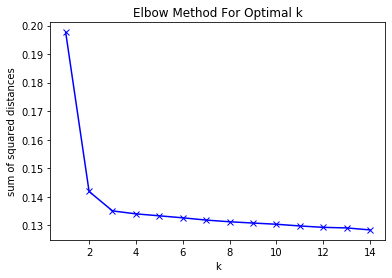

In [73]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

After k=3, sum of squared distance doesn't change much, so we choose k=3 for HE1.

In [74]:
kmeans0 = KMeans(n_clusters=2, random_state=0)
clusters0_km = kmeans0.fit_predict(newhe0.T)

In [75]:
kmeans1 = KMeans(n_clusters=3, random_state=42)
clusters1_km = kmeans1.fit_predict(newhe1.T)

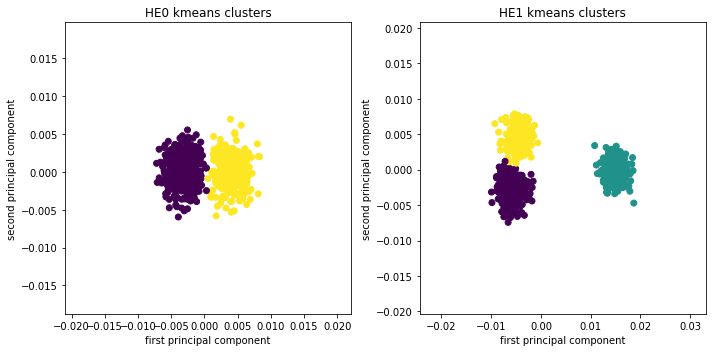

In [76]:
fig, axes= plt.subplots(nrows=1, ncols=2,figsize=(10,5))

x = newhe0_plot.T[0]
y = newhe0_plot.T[1]
axes[0].scatter(x, y, c = clusters0_km)
axes[0].set_xlabel('first principal component')
axes[0].set_ylabel('second principal component')
axes[0].set_title('HE0 kmeans clusters')

x1 = newhe1_plot.T[0]
y1 = newhe1_plot.T[1]
axes[1].scatter(x1, y1, c = clusters1_km)
axes[1].set_xlabel('first principal component')
axes[1].set_ylabel('second principal component')
axes[1].set_title('HE1 kmeans clusters')

plt.tight_layout()
plt.show()

### b. GMM

In [78]:
gm0 = GaussianMixture(n_components=2, random_state=0)
clusters0_gm = gm0.fit_predict(newhe0.T)

In [79]:
gm1 = GaussianMixture(n_components=3, random_state=0)
clusters1_gm = gm1.fit_predict(newhe1.T)

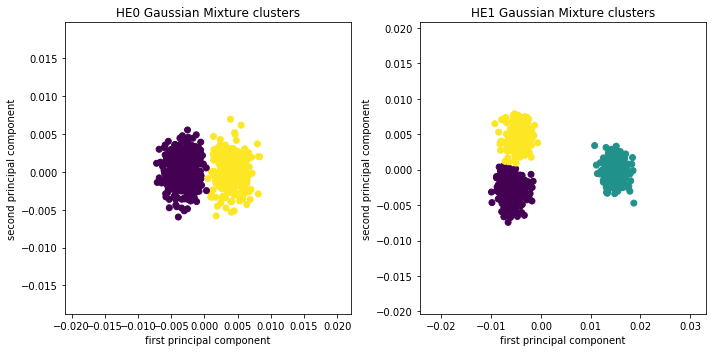

In [80]:
fig, axes= plt.subplots(nrows=1, ncols=2,figsize=(10,5))

x = newhe0_plot.T[0]
y = newhe0_plot.T[1]
axes[0].scatter(x, y, c = clusters0_gm)
axes[0].set_xlabel('first principal component')
axes[0].set_ylabel('second principal component')
axes[0].set_title('HE0 Gaussian Mixture clusters')

x1 = newhe1_plot.T[0]
y1 = newhe1_plot.T[1]
axes[1].scatter(x1, y1, c = clusters1_gm)
axes[1].set_xlabel('first principal component')
axes[1].set_ylabel('second principal component')
axes[1].set_title('HE1 Gaussian Mixture clusters')

plt.tight_layout()
plt.show()

### c. Single and Complete Linkage Hierarchical

#### Single Linkage 

In [81]:
hc0_single = AgglomerativeClustering(n_clusters=2, linkage='single')
clusters0_hc_single = hc0_single.fit_predict(newhe0.T)

In [82]:
hc1_single = AgglomerativeClustering(n_clusters=3, linkage='single')
clusters1_hc_single = hc1_single.fit_predict(newhe1.T)

In [83]:
hc0_complete = AgglomerativeClustering(n_clusters=2, linkage='complete')
clusters0_hc_complete = hc0_complete.fit_predict(newhe0.T)

In [84]:
hc1_complete = AgglomerativeClustering(n_clusters=3, linkage='complete')
clusters1_hc_complete = hc1_complete.fit_predict(newhe1.T)

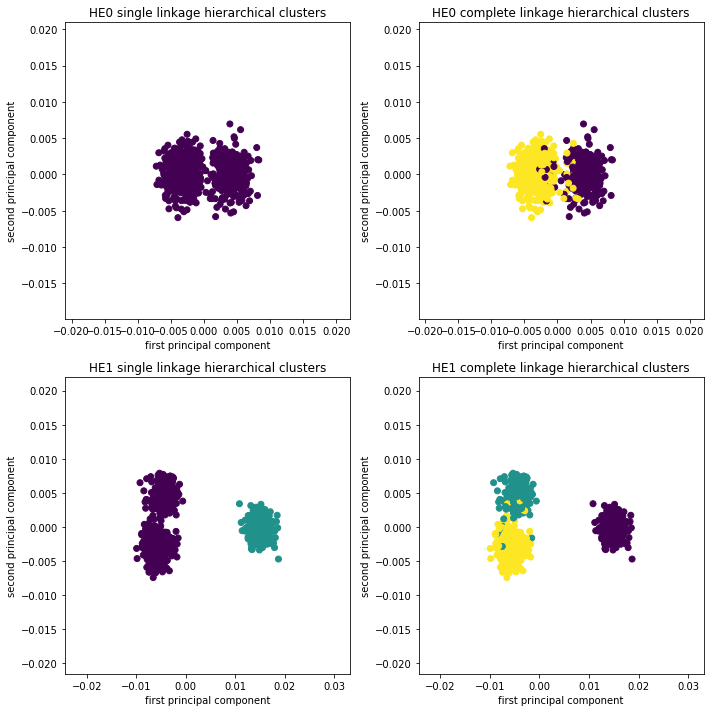

In [85]:
fig, axes= plt.subplots(nrows=2, ncols=2,figsize=(10,10))

x = newhe0_plot.T[0]
y = newhe0_plot.T[1]
axes[0][0].scatter(x, y, c = clusters0_hc_single)
axes[0][0].set_xlabel('first principal component')
axes[0][0].set_ylabel('second principal component')
axes[0][0].set_title('HE0 single linkage hierarchical clusters')

x1 = newhe1_plot.T[0]
y1 = newhe1_plot.T[1]
axes[1][0].scatter(x1, y1, c = clusters1_hc_single)
axes[1][0].set_xlabel('first principal component')
axes[1][0].set_ylabel('second principal component')
axes[1][0].set_title('HE1 single linkage hierarchical clusters')

x = newhe0_plot.T[0]
y = newhe0_plot.T[1]
axes[0][1].scatter(x, y, c = clusters0_hc_complete)
axes[0][1].set_xlabel('first principal component')
axes[0][1].set_ylabel('second principal component')
axes[0][1].set_title('HE0 complete linkage hierarchical clusters')

x1 = newhe1_plot.T[0]
y1 = newhe1_plot.T[1]
axes[1][1].scatter(x1, y1, c = clusters1_hc_complete)
axes[1][1].set_xlabel('first principal component')
axes[1][1].set_ylabel('second principal component')
axes[1][1].set_title('HE1 complete linkage hierarchical clusters')

plt.tight_layout()
plt.show()

### d. Single vs Complete Link Hierarchical Clustering

Compared to complete linkage hierarchical clustering, single linkage clustering tends to connect any clusters that are close to each other. As shown in the graphs, single linkage clustering combines the two clusters ni HE0 because there are some points (noise points) between them. 

Complete linkage clustering prefers spherical clusters. As the two clusters in HE1 are elliptical, complete linkage clustering assigned some points wrongly to make the clusters spherical. 

### e. Comparing Clustering Techniques

K-means is efficient and gets a good clustering result on both HE0 and HE1. But the random choice of cluster centers affect the final results so the performance can be unstable. 


Gaussian mixture model is more flexible than K-means as it assumes the data points are Gaussion distributed while K-means assumes they are circular. As the data points are distributed evenly in our dataset, both clustering results look good. 

For the two kinds of hierarchical clustering, the clustering results are worse than that of the previous two. Single link hierarchical clustering gets a wired result because it is sensitive to the noise between the two clusters. Clustering result of complete link hierarchical clustering has vague boundaries because it prefers spherical clusters. 

Clustering result of GMM is selected for the following analyses. 

### f. What do Clusters Represent

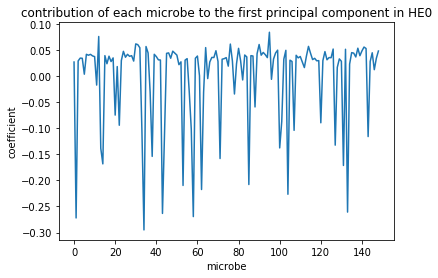

In [86]:
plt.plot(pca0_plot.components_[0])
plt.title('contribution of each microbe to the first principal component in HE0')
plt.ylabel('coefficient')
plt.xlabel('microbe')
plt.show()

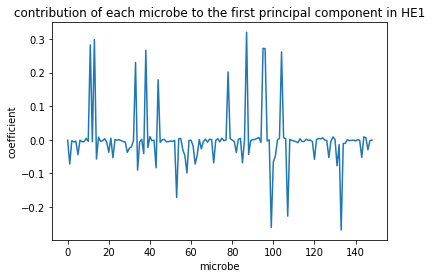

In [87]:
plt.plot(pca1_plot.components_[0])
plt.title('contribution of each microbe to the first principal component in HE1')
plt.ylabel('coefficient')
plt.xlabel('microbe')
plt.show()

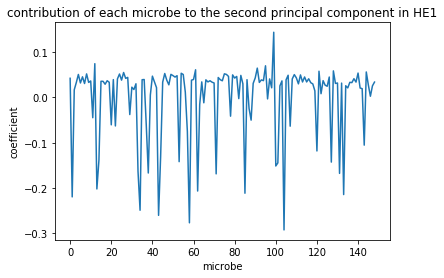

In [88]:
plt.plot(pca1_plot.components_[1])
plt.title('contribution of each microbe to the second principal component in HE1')
plt.ylabel('coefficient')
plt.xlabel('microbe')
plt.show()

There are two subpopulaion in HE0 separated mostly by the first component and three subpopulation in HE1 separated by both the first and second principle component. 

### g. Deciding on Number of Clusters

Noise points might result in inaccurate result. Noise points can make the elbow in our method ambiguous (not so clear and sharp). 

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

In [93]:
pd.DataFrame(clusters1_gm)[0]

0      0
1      1
2      0
3      1
4      1
      ..
694    2
695    0
696    2
697    2
698    2
Name: 0, Length: 699, dtype: int64

In [102]:
pd.DataFrame(clusters0_gm)[0]

0      1
1      1
2      1
3      1
4      0
      ..
694    1
695    0
696    0
697    1
698    0
Name: 0, Length: 699, dtype: int64

### c. Identify Microbes with Significantly Altered Relative Abundance

In [109]:
from scipy import stats

p_values = []
for i in range(newhe0.shape[0]):
    p_value = stats.ks_2samp(gm0.means_[i,0:], gm1.means_[i,0:])
    p_values.append(p_value[1])

p_values = pd.Series(p_values)
p_values

IndexError: index 2 is out of bounds for axis 0 with size 2

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

### b. Biological Relations